## Downstream Tasks

This section is for our downstream tasks which we want our embeddings to do well on. Currently we have language encoding and decoding implemented. This works as follows:

1. Generate a dataset with (GPT-2 embeddings of heard words, low dimensional embeddings of the neural data starting from some offset of the word onset).
2. Train a linear model to either go from the word embeddings to neural data (encoding) or neural data to word embeddings (decoding).
3. Report performance.

Pretty simple! While language encoding and decoding are a big goal, we would like to try using the embeddings in simpler tasks first. Here are some ideas that you could try implementing and testing:

1. A binary classifier where the model predicts if the subject is hearing a word at that moment or not. This would entail modifying the data loader to load neural signals which occur during word onsets and offsets and some that do not. Deciding how to balance the weights of those examples is up to you.
2. A volume regressor which goes from the neural embedding to the volume of the sound that the subject is hearing at that moment. You would need to modify the data loader to grab neural signals and the average volume during that signal.
3. Right now we only train a single linear layer on top of the model without passing gradients back to the model. It would be interesting to see how it performs if we finetune our model on these downstream tasks and could be implemented without much trouble.
4. Anything else! You can see what kind of data we have access to in the data section below.

P.S. Make sure the model is in eval mode (call model.eval()) before doing anything with it here!

In [1]:
# The local path to the github repo. Must be accessible from this notebook.
# For compute cluster or local machine.
path_to_github_repo = '../'

# For Colab.
# path_to_github_repo = 'ECoG-foundation-model/'

In [2]:
import os
import sys
import torch

sys.path.append(os.path.join(path_to_github_repo, 'ECoG_MAE'))
from mae_st_util.models_mae import MaskedAutoencoderViT
from config import create_video_mae_experiment_config_from_file
from ecog_setup import create_model

In [3]:
# Device to train on.
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
# First load the model and set it in eval mode.
model_dir = "models"
ecog_config = create_video_mae_experiment_config_from_file(os.path.join(model_dir, "experiment_config.ini"))

model = create_model(ecog_config)
model.load_state_dict(torch.load(os.path.join(model_dir, "model.pth"), weights_only=True))

model.eval()

img_size (8, 8) patch_size (2, 2) frames 128 t_patch_size 4
model initialized


MaskedAutoencoderViT(
  (masked_input_norm): MaskedBatchNorm(
    (bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  )
  (patch_embed): PatchEmbed(
    (proj): Conv3d(1, 16, kernel_size=(4, 2, 2), stride=(4, 2, 2))
  )
  (blocks): ModuleList(
    (0-5): 6 x Block(
      (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (q): Linear(in_features=16, out_features=16, bias=True)
        (k): Linear(in_features=16, out_features=16, bias=True)
        (v): Linear(in_features=16, out_features=16, bias=True)
        (proj): Linear(in_features=16, out_features=16, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=16, out_features=32, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Id

### Data

For this part of the project we have access to the data in word-embeddings/ and preprocessed-highgamma/. Note that the .mat files in preprocessed-highgamma already have been preprocessed to high-gamma so there's no need for more filtering here.

You can load data in the preprocessed-highgamma data like so:

In [50]:
# Load data for the first electrode
data = scipy.io.loadmat('../preprocessed-highgamma/NY798_111_Part1_conversation1_electrode_preprocess_file_1.mat')['p1st'].flatten()
data.shape

(915602,)

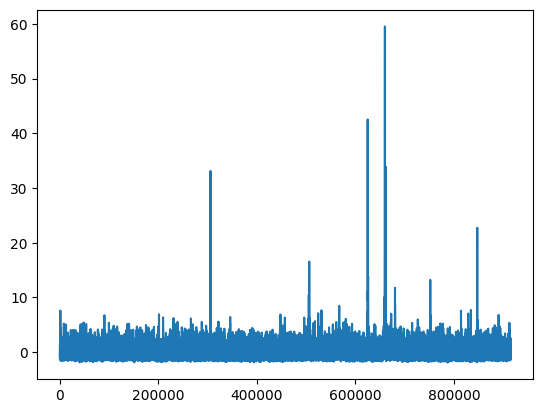

In [51]:
plt.plot(data)
plt.show()

If you want to load them all into a nice electrode grid see the dataloader code below for that. We can also see what kind of data we have access to in our word embeddings. 

In [52]:
conversation_data = pd.read_csv('../word-embeddings/gpt2-layer-8-emb.pkl', index_col=0)
# Convert embeddings from string to array. Index out "[]" from string.
conversation_data.loc[:, "embeddings"] = conversation_data.loc[
    :, "embeddings"
].apply(lambda x: np.fromstring(x[1:-1], sep=", "))
# Limit only to words with onset time data.
conversation_data = conversation_data.loc[
    conversation_data["onset"].dropna().index
]
conversation_data

,word,word_without_punctuation,index,datum_word,onset,offset,accuracy,speaker,is_nonword,cloze,...,in_bert-large-cased,in_roberta-base,in_roberta-large,top1_pred,top1_pred_prob,true_pred_prob,true_pred_rank,surprise,entropy,embeddings
8,So,So,0.0,So,356.1457,427.8257,1.0,Speaker2,False,0.04,...,False,True,True,\n,0.194265,0.002317,45.0,0.020285,8.105922,"[-0.13344508409500122, -4.483438491821289, -2...."
9,there's,there's,1.0,there's,438.0657,519.9857,1.0,Speaker2,False,0.02,...,False,True,True,",",0.172101,0.020413,11.0,0.114605,6.571477,"[3.2388994693756104, -1.0490363836288452, -1.6..."
10,there's,there's,1.0,there's,438.0657,519.9857,1.0,Speaker2,False,0.02,...,False,True,True,'s,0.343256,0.343256,1.0,0.529522,3.673014,"[-0.3139915466308594, -2.5767409801483154, -0...."
11,some,some,2.0,some,509.7457,591.6657,1.0,Speaker2,False,0.02,...,False,True,True,a,0.269538,0.027120,7.0,0.141145,5.795166,"[-0.774554431438446, -3.086632490158081, -1.34..."
12,places,places,3.0,places,601.9057,740.1457,1.0,Speaker2,False,0.04,...,False,True,True,sort,0.033894,0.000159,766.0,0.002006,9.948091,"[-1.698758840560913, -3.107893943786621, -4.48..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6128,it's,it's,5108.0,it's,914626.0608,914677.2608,1.0,Speaker2,False,0.02,...,False,True,True,'s,0.522330,0.522330,1.0,0.489406,3.837202,"[-3.0750534534454346, -3.043199062347412, 4.13..."
6129,a,a,5109.0,a,914697.7408,914707.9808,1.0,Speaker2,False,0.06,...,False,True,True,not,0.161952,0.074484,3.0,0.279085,6.727214,"[1.5721521377563477, 0.7583765387535095, 0.252..."
6130,uniquely,uniquely,5110.0,uniquely,914748.9408,914938.3808,1.0,Speaker2,False,0.02,...,False,True,True,very,0.062961,0.000686,184.0,0.007208,8.915740,"[-0.6058820486068726, 2.3530914783477783, 2.08..."
6131,human,human,5111.0,human,914969.1008,915097.1008,1.0,Speaker2,False,0.26,...,False,True,True,human,0.424989,0.424989,1.0,0.524650,5.993249,"[6.587402820587158, 3.085411548614502, -1.1317..."


In [53]:
conversation_data.columns

Index(['word', 'word_without_punctuation', 'index', 'datum_word', 'onset',
       'offset', 'accuracy', 'speaker', 'is_nonword', 'cloze',
       'sentence_signal_length', 'sentence', 'num_words', 'sentence_idx',
       'adjusted_onset', 'adjusted_offset', 'conversation_id',
       'conversation_name', 'production', 'word_freq_overall',
       'word_freq_phase', 'lemmatized_word', 'stemmed_word', 'in_glove',
       'token', 'token2word', 'token_id', 'gpt2_token_is_root', 'token_idx',
       'in_gpt2', 'in_gpt2-large', 'in_gpt2-xl', 'in_gpt-neo-125M',
       'in_gpt-neo-1.3B', 'in_gpt-neo-2.7B', 'in_gpt-neox-20b', 'in_opt-125m',
       'in_opt-350m', 'in_opt-1.3b', 'in_opt-2.7b', 'in_opt-6.7b',
       'in_opt-30b', 'in_blenderbot_small-90M', 'in_blenderbot-3B',
       'in_whisper-tiny.en', 'in_whisper-base', 'in_whisper-small',
       'in_whisper-medium', 'in_whisper-large', 'in_bert-base-uncased',
       'in_bert-large-uncased', 'in_bert-base-cased', 'in_bert-large-cased',
       'in_ro

In [54]:
conversation_data[['word', 'token', 'onset', 'offset', 'embeddings']]

,word,token,onset,offset,embeddings
8,So,ĠSo,356.1457,427.8257,"[-0.13344508409500122, -4.483438491821289, -2...."
9,there's,Ġthere,438.0657,519.9857,"[3.2388994693756104, -1.0490363836288452, -1.6..."
10,there's,'s,438.0657,519.9857,"[-0.3139915466308594, -2.5767409801483154, -0...."
11,some,Ġsome,509.7457,591.6657,"[-0.774554431438446, -3.086632490158081, -1.34..."
12,places,Ġplaces,601.9057,740.1457,"[-1.698758840560913, -3.107893943786621, -4.48..."
...,...,...,...,...,...
6128,it's,'s,914626.0608,914677.2608,"[-3.0750534534454346, -3.043199062347412, 4.13..."
6129,a,Ġa,914697.7408,914707.9808,"[1.5721521377563477, 0.7583765387535095, 0.252..."
6130,uniquely,Ġuniquely,914748.9408,914938.3808,"[-0.6058820486068726, 2.3530914783477783, 2.08..."
6131,human,Ġhuman,914969.1008,915097.1008,"[6.587402820587158, 3.085411548614502, -1.1317..."


These are likely the primary columns of interest. Notice that there can be multiple rows per word if the word is broken up into multiple tokens. There is actually a bug in the current dataloader relating to this because we don't do anything to handle this duplication so you could try to fix this too if you want!

Feel free to use whatever columns you are interested in. You can corrolaries for most of them in this [paper](https://hassonlab.princeton.edu/sites/g/files/toruqf3591/files/documents/Goldstein_et_al_NN_2022.pdf) mentioned before.

In [55]:
conversation_data['speaker'].unique()

array(['Speaker2'], dtype=object)

All of these are heard words, not spoken.

In [56]:
(conversation_data['onset'] == conversation_data['adjusted_onset']).all(), (conversation_data['offset'] == conversation_data['adjusted_offset']).all()

(np.True_, np.True_)

Don't worry about differences between onset and adjusted_onset they're all the same.

### Dataloader

Whatever you implement for a downstream task will likely need to update this code so I'm including it here for ease of access. Most changes will involve changing how we gather this data and the associated label (i.e. if you want to do the "word present" classifier you would change the word embedding label to a 1 or 0 depending on whether a word is present in that sample or not).

In [57]:
import glob

from utils import preprocess_neural_data
from downstream_tasks.encoding_decoding.config import EncodingDecodingDataConfig

class EncodingDecodingDataset:
    def __init__(self, config: EncodingDecodingDataConfig):
        self.config = config
        self.encoding_neural_data_folder = config.encoding_neural_data_folder
        self.electrode_glob_path = config.electrode_glob_path
        self.fs = config.original_fs
        self.lag = config.lag
        self.new_fs = config.new_fs
        self.sample_secs = config.sample_length
        # Track which electrodes are accessible and which are padding
        self.padding_mask = None

        self.signal = self._load_grid_data()
        conversation_data = pd.read_csv(config.conversation_data_df_path, index_col=0)
        # Convert embeddings from string to array. Index out "[]" from string.
        conversation_data.loc[:, "embeddings"] = conversation_data.loc[
            :, "embeddings"
        ].apply(lambda x: np.fromstring(x[1:-1], sep=", "))

        # Limit only to words with onset time data.
        self.timed_word_data = conversation_data.loc[
            conversation_data["onset"].dropna().index
        ]

        # since we take sample_length sec samples, the number of samples we can stream from our dataset is determined by the duration of the chunk in sec divided by sample_length.
        # Optionally can configure max_samples directly as well.
        self.max_samples = self.signal.shape[1] / self.fs / config.sample_length

        self.index = 0

    def _load_grid_data(self):
        grid_data = []
        # TODO: Test padding mask
        self.padding_mask = torch.zeros(8, 8, dtype=bool)
        # Used to ensure all electrode data is of the same length.
        expected_len = 0
        for i in range(64):
            curr_electrode_glob_path = self.electrode_glob_path.format(
                elec_id=str(i + 1)
            )
            final_glob_path = os.path.join(
                self.encoding_neural_data_folder, curr_electrode_glob_path
            )
            electrode_file = glob.glob(final_glob_path)

            if len(electrode_file) > 1:
                raise ValueError(
                    "There can only be one matching file associated with electrode {}. Got {} files matching {}.".format(
                        i + 1, len(electrode_file), final_glob_path
                    )
                )
            elif len(electrode_file) == 0:
                print(
                    "No files found for electrode {}. Got 0 files matching {}.".format(
                        i + 1, final_glob_path
                    )
                )
                # Append None to be padded with 0's later.
                grid_data.append(None)
            else:
                data = scipy.io.loadmat(electrode_file[0])["p1st"].flatten()

                if not expected_len:
                    expected_len = data.size
                else:
                    if data.size != expected_len:
                        raise ValueError(
                            "Data size does not match for electrode {} at path: {}. Expected size: {}. Actual size: {}".format(
                                i + 1, final_glob_path, expected_len, data.size
                            )
                        )

                grid_data.append(data)
                # Update padding_mask to include this electrode as valid.
                self.padding_mask[i // 8, i % 8] = True
        padded_data = []
        for data in grid_data:
            # Pad zero's for held out data.
            if data is None:
                padded_data.append(np.zeros((expected_len)))
            else:
                padded_data.append(data)

        return np.array(padded_data)

    def __iter__(self):
        """Iterate through dataset for encoding task.

        Yields:
            tuple[np.array, np.array]: (word embedding, neural data)
        """
        while self.index < self.timed_word_data.shape[0]:
            word_data = self.timed_word_data.iloc[self.index]

            # TODO: Add configurable way to filter out examples which require padding if we want to train
            # without them. Same for VideoMAE dataloader.
            lag_start_time = word_data.loc["onset"] + self.lag
            lag_start_sample = int(lag_start_time / 1000 * self.fs)
            # TODO: Change to ms.
            lag_end_sample = lag_start_sample + self.fs * self.sample_secs

            # If we are gathering a sample from before the start of the signal or ends after the signal continue.
            if lag_start_sample < 0 or lag_end_sample > self.signal.shape[1]:
                self.index += 1
                continue

            curr_sample = self.signal[:, lag_start_sample:lag_end_sample]

            preprocessed_signal = preprocess_neural_data(
                curr_sample,
                self.fs,
                self.new_fs,
                self.sample_secs,
            )

            yield word_data.loc["embeddings"], preprocessed_signal

            self.index += 1

        if self.index >= self.timed_word_data.shape[0]:
            self.index = 0

### Helper Functions

These functions may be generally useful for implementing new tasks, especially the one for generating the dataset which processes the neural data into neural embeddings.

In [ ]:
from dataclasses import asdict, replace
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity

def get_correlation_metrics(groundtruth, predicted):
    """
    Calculate summary correlation metrics for two sets of embeddings.

    Args:
    groundtruth (np.array): shape [num_embeddings, embedding_dim]
    predicted (np.array): shape [num_embeddings, embedding_dim]

    Returns:
    dict: A dictionary containing various correlation metrics
    """
    # Flatten the matrices
    gt_flat = groundtruth.flatten()
    pred_flat = predicted.flatten()

    # Calculate overall Pearson correlation
    overall_corr, overall_p = stats.pearsonr(gt_flat, pred_flat)

    # Calculate per-dimension correlations
    dim_corrs = np.array([stats.pearsonr(groundtruth[:, i], predicted[:, i])[0] 
                          for i in range(groundtruth.shape[1])])

    # Calculate per-embedding correlations
    emb_corrs = np.array([stats.pearsonr(groundtruth[i, :], predicted[i, :])[0] 
                          for i in range(groundtruth.shape[0])])

    return {
        "overall_correlation": overall_corr,
        "overall_p_value": overall_p,
        "dimension_correlation": dim_corrs,
        "embedding_correlation": emb_corrs,
        "mean_dimension_correlation": np.mean(dim_corrs),
        "mean_embedding_correlation": np.mean(emb_corrs),
        "median_dimension_correlation": np.median(dim_corrs),
        "median_embedding_correlation": np.median(emb_corrs)
    }

@torch.no_grad()
def generate_embedding_dataset(
    dataset: EncodingDecodingDataset, model: nn.Module, embedding_batch_size: int, device: str
) -> tuple[np.array, np.array]:
    """Gathers word embeddings and generates neural embeddings using model from the dataset.

    Args:
        dataset (EncodingDecodingDataset): dataset used to gather word and neural data.
        model (nn.Module): model used to generate neural embeddings. Expected as of now to output embeddings of shape
            [batch_size, num_tokens, output_dim] where num_tokens is the number of patches for the VideoMAE model, although different
            models could be plugged in here as well. Embeddings are joined together using average pooling to form one summary embedding.
        embedding_batch_size (int): The number of neural examples to pass into the model per-inference. Can speed up inference by
            parallelizing at the cost of RAM or VRAM.
        device (str): The name of the device to run inference on. Model is assumed to already be on this device.

    Returns:
        tuple[np.array, np.array]: (word_embeddings, neural_embeddings) both parallel arrays containing the embeddings for our examples.
    """
    model.eval()

    print("padding mask:", dataset.padding_mask)
    model.initialize_mask(dataset.padding_mask.to(device))

    # Setup dataloader and iterate through examples.
    word_embeddings = []
    neural_embeddings = []
    
    def _generate_neural_embeddings(neural_batch: list):
        neural_data = torch.cat(neural_batch)
        neural_data = neural_data.to(device)

        # Model output is shape:
        # [batch_size, output_dim]
        # Does average pooling on data.
        model_outputs = model(neural_data, forward_features=True)

        for embedding in model_outputs:
            neural_embeddings.append(embedding.detach().cpu().numpy())

    # Collect data into batches to accelerate inference.
    neural_batch = []
        
    for word_embedding, neural_data in dataset:
        word_embeddings.append(word_embedding)
        batch_ready_neural_data = np.expand_dims(neural_data, 0)
        neural_batch.append(torch.from_numpy(batch_ready_neural_data))

        if len(neural_batch) == embedding_batch_size:
            _generate_neural_embeddings(neural_batch)
            neural_batch = []
            
    # Catch any remaining examples.
    if len(neural_batch) > 0:
        _generate_neural_embeddings(neural_batch)
        neural_batch = []

    word_embeddings = np.array(word_embeddings)
    neural_embeddings = np.array(neural_embeddings)

    model.initialize_mask(None)
    model.train()

    return word_embeddings, neural_embeddings


def merge_data_configs(
    encoding_data_config: EncodingDecodingDataConfig, ecog_data_config: ECoGDataConfig
) -> EncodingDecodingDataConfig:
    """Overwrites fields in encoding_data_config with the fields set in ecog_data_config.

    Args:
        encoding_data_config (EncodingDecodingDataConfig): encoding data config which will have fields overwritten.
        ecog_data_config (ECoGDataConfig): ecog data config which contains field to overwrite in encoding_data_config

    Returns:
        EncodingDecodingDataConfig: config with ECoGDataConfig fields overwritten other than original_fs
    """
    # Maintain original_fs from encoding_config because it could be different than the one for pretraining.
    encoding_original_fs = encoding_data_config.original_fs
    updated_config = replace(encoding_data_config, **asdict(ecog_data_config))
    updated_config.original_fs = encoding_original_fs
    return updated_config


def run_regression(X: np.array, Y: np.array, num_folds: int) -> np.array:
    """Builds a linear regression model from X->Y using num_folds folds.

    Args:
        X (np.array): Shape [num_examples, num_variables] the independent variable.
        Y (np.array): Shape [num_examples, num_variables] the dependent variable.
        num_folds (int): Number of folds to run training/testing over.

    Returns:
        predicted_values: np.array of shape [num_examples, num_variables] where the ith row corresponds to a prediction of
            the ith in Y, generated when the fold containing the ith row was in the test set.
    """
    # Make folds of data.
    kf = KFold(n_splits=num_folds)

    # Used to track predictions for
    all_predictions = np.zeros_like(Y)

    # TODO: Allow for adding a torch linear head to model which can be used to pass gradients backwards and finetune the
    # model if that's something we choose to do in the future. Using sklearn for now because it's simple and easily
    # runs on cpu. Can also allow for non-linearities in torch model if necessary.
    for train_index, test_index in kf.split(X):
        train_x, test_x = X[train_index], X[test_index]
        train_y = Y[train_index]

        model = make_pipeline(StandardScaler(), LinearRegression())

        model.fit(train_x, train_y)

        predictions = model.predict(test_x)

        all_predictions[test_index, :] = predictions

    return all_predictions

### Config

Current config setup.

In [59]:
from downstream_tasks.encoding_decoding.config import EncodingDecodingExperimentConfig, EncodingDecodingTaskConfig, EncodingDecodingDataConfig
from downstream_tasks.encoding_decoding.utils import run_encoding_task, run_decoding_task

In [ ]:
encoding_experiment_config = EncodingDecodingExperimentConfig(
    encoding_data_config = EncodingDecodingDataConfig(
        conversation_data_df_path = os.path.join(path_to_github_repo, "word-embeddings/gpt2-layer-8-emb.pkl"),
        encoding_neural_data_folder = os.path.join(path_to_github_repo, "preprocessed-highgamma"),
        electrode_glob_path = "NY*_*_Part*_conversation*_electrode_preprocess_file_{elec_id}.mat",
        lag = 0
    ),
    encoding_task_config = EncodingDecodingTaskConfig(
        model_path = "", # Unused here.
        embedding_device = device,
        embedding_batch_size = 8,
        num_folds = 2,
    )
)

### Encoding

This is our encoding task (word-embeddings -> neural embeddings).

In [73]:
encoding_data_config = merge_data_configs(
    encoding_experiment_config.encoding_data_config, ecog_config.ecog_data_config
)

dataset = EncodingDecodingDataset(encoding_data_config)

word_embeddings, neural_embeddings = generate_embedding_dataset(
    dataset,
    model,
    encoding_experiment_config.encoding_task_config.embedding_batch_size,
    encoding_experiment_config.encoding_task_config.embedding_device,
)

predictions = run_regression(
    word_embeddings,
    neural_embeddings,
    encoding_experiment_config.encoding_task_config.num_folds,
)

correlation_metrics_encoding = get_correlation_metrics(neural_embeddings, predictions)

cosine_sim_metrics_encoding = cosine_similarity(neural_embeddings, predictions)

mspe_encoding = np.square(neural_embeddings - predictions).mean()

No files found for electrode 9. Got 0 files matching ../preprocessed-highgamma/NY*_*_Part*_conversation*_electrode_preprocess_file_9.mat.
No files found for electrode 59. Got 0 files matching ../preprocessed-highgamma/NY*_*_Part*_conversation*_electrode_preprocess_file_59.mat.
No files found for electrode 60. Got 0 files matching ../preprocessed-highgamma/NY*_*_Part*_conversation*_electrode_preprocess_file_60.mat.
No files found for electrode 61. Got 0 files matching ../preprocessed-highgamma/NY*_*_Part*_conversation*_electrode_preprocess_file_61.mat.
padding mask: tensor([[ True,  True,  True,  True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  T

In [74]:
correlation_metrics_encoding

{'overall_correlation': np.float64(0.08921885311122751),
 'overall_p_value': np.float32(0.0),
 'dimension_correlation': array([-0.05403258, -0.03320565,  0.09859984,  0.05056833,  0.07959674,
        -0.04967352, -0.0312699 ,  0.09559993,  0.06677794,  0.07828864,
         0.04077907, -0.05981023,  0.05970785,  0.06430414,  0.09231448,
        -0.04050403]),
 'embedding_correlation': array([ 0.31093988,  0.06866968,  0.06528332, ...,  0.44671828,
         0.42354782, -0.60863047]),
 'mean_dimension_correlation': np.float64(0.02862756584024372),
 'mean_embedding_correlation': np.float64(0.05821150774730866),
 'median_dimension_correlation': np.float64(0.05513809018072449),
 'median_embedding_correlation': np.float64(0.13116525405348511)}

In [75]:
# MSPE is not very useful in high dimensions, prefer to use cosine similarity or correlation (which is actually just cosine similarity with 0 mean)
mspe_encoding

np.float32(39987930000.0)

In [76]:
# We are primarily interested in the diagonal distances. ith prediction compared to ith groundtruth.
np.diag(cosine_sim_metrics_encoding)

array([ 0.2699872 ,  0.04146124,  0.03587702, ...,  0.43757004,
        0.42838106, -0.6119749 ], dtype=float32)

### Decoding

Note that decoding is just encoding but with the input and target variables switched. Now neural embeddings -> word embeddings.

In [69]:
decoding_data_config = merge_data_configs(
    encoding_experiment_config.encoding_data_config, ecog_config.ecog_data_config
)

dataset = EncodingDecodingDataset(encoding_data_config)

word_embeddings, neural_embeddings = generate_embedding_dataset(
    dataset,
    model,
    encoding_experiment_config.encoding_task_config.embedding_batch_size,
    encoding_experiment_config.encoding_task_config.embedding_device,
)

predictions = run_regression(
    neural_embeddings,
    word_embeddings,
    encoding_experiment_config.encoding_task_config.num_folds,
)

correlation_metrics_decoding = get_correlation_metrics(word_embeddings, predictions)
mspe_decoding = np.square(word_embeddings - predictions).mean()
cosine_sim_metrics_decoding = cosine_similarity(word_embeddings, predictions)

No files found for electrode 9. Got 0 files matching ../preprocessed-highgamma/NY*_*_Part*_conversation*_electrode_preprocess_file_9.mat.
No files found for electrode 59. Got 0 files matching ../preprocessed-highgamma/NY*_*_Part*_conversation*_electrode_preprocess_file_59.mat.
No files found for electrode 60. Got 0 files matching ../preprocessed-highgamma/NY*_*_Part*_conversation*_electrode_preprocess_file_60.mat.
No files found for electrode 61. Got 0 files matching ../preprocessed-highgamma/NY*_*_Part*_conversation*_electrode_preprocess_file_61.mat.
padding mask: tensor([[ True,  True,  True,  True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  T

In [70]:
correlation_metrics_decoding

{'overall_correlation': np.float64(0.6612710062173627),
 'overall_p_value': np.float64(0.0),
 'dimension_correlation': array([ 2.04295270e-02, -2.27029405e-02,  8.06532269e-03, -2.12710066e-02,
        -6.64142614e-02,  3.19834851e-02, -3.93059692e-02, -4.33604094e-02,
        -1.79393752e-02, -2.98978060e-02,  1.20554469e-03, -1.68862287e-02,
        -9.39533549e-04, -4.70182909e-03,  7.42343494e-03, -3.55270492e-02,
        -3.17225109e-02, -2.73973549e-03, -5.69697863e-02,  4.74830362e-02,
        -6.90403091e-02, -9.73817257e-02, -1.17746033e-01, -4.77820765e-02,
        -3.18949500e-02, -6.14904572e-02, -9.68584119e-03,  2.23279083e-02,
        -1.79587090e-02, -1.14882871e-02, -7.08157595e-02, -1.32721398e-01,
         3.87375975e-03, -6.24297426e-02, -2.24568150e-03, -4.42415503e-02,
        -4.66377526e-02, -2.17995207e-02, -4.17129422e-02, -3.01430513e-02,
        -6.21342661e-02, -2.16423516e-02, -2.67077060e-03, -2.99814471e-02,
        -2.49954981e-02, -5.71153934e-02, -8.4

In [71]:
mspe_decoding

np.float64(7.666171667972233)

In [72]:
np.diag(cosine_sim_metrics_decoding)

array([0.5400652 , 0.52196837, 0.44877155, ..., 0.74616543, 0.61855163,
       0.65767508])

### Baselining these tasks

As a baseline let's run encoding and decoding with an untrained model which can be used to see what effects training has had.

In [77]:
untrained_model, _, _ = setup_model()

num_patches 1024
num_encoder_patches 768
num_decoder_patches 1024
patch dimensionality 16
encoder embedding dimensionality 16
decoder embedding dimensionality 16
img_size (8, 8) patch_size (2, 2) frames 128 t_patch_size 4
model initialized
param counts:
22,448 total
22,448 trainable


#### Encoding

In [78]:
encoding_data_config = merge_data_configs(
    encoding_experiment_config.encoding_data_config, ecog_config.ecog_data_config
)

dataset = EncodingDecodingDataset(encoding_data_config)

word_embeddings, neural_embeddings = generate_embedding_dataset(
    dataset,
    untrained_model,
    encoding_experiment_config.encoding_task_config.embedding_batch_size,
    encoding_experiment_config.encoding_task_config.embedding_device,
)

predictions = run_regression(
    word_embeddings,
    neural_embeddings,
    encoding_experiment_config.encoding_task_config.num_folds,
)

correlation_metrics_enc_baseline = get_correlation_metrics(neural_embeddings, predictions)

cosine_sim_metrics_enc_baseline = cosine_similarity(neural_embeddings, predictions)

mspe_enc_baseline = np.square(neural_embeddings - predictions).mean()

No files found for electrode 9. Got 0 files matching ../preprocessed-highgamma/NY*_*_Part*_conversation*_electrode_preprocess_file_9.mat.
No files found for electrode 59. Got 0 files matching ../preprocessed-highgamma/NY*_*_Part*_conversation*_electrode_preprocess_file_59.mat.
No files found for electrode 60. Got 0 files matching ../preprocessed-highgamma/NY*_*_Part*_conversation*_electrode_preprocess_file_60.mat.
No files found for electrode 61. Got 0 files matching ../preprocessed-highgamma/NY*_*_Part*_conversation*_electrode_preprocess_file_61.mat.
padding mask: tensor([[ True,  True,  True,  True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  T

In [79]:
correlation_metrics_enc_baseline

{'overall_correlation': np.float64(0.08848809764511045),
 'overall_p_value': np.float32(0.0),
 'dimension_correlation': array([0.096358  , 0.10162078, 0.06384222, 0.04915722, 0.00860763,
        0.05549028, 0.09215233, 0.04644525, 0.07399268, 0.06009063,
        0.02300932, 0.05116737, 0.07779752, 0.08051954, 0.07855005,
        0.01517785]),
 'embedding_correlation': array([ 0.55572575,  0.32568157,  0.32022963, ...,  0.18394756,
         0.13500682, -0.65420628]),
 'mean_dimension_correlation': np.float64(0.06087366704789632),
 'mean_embedding_correlation': np.float64(0.06023617899148209),
 'median_dimension_correlation': np.float64(0.061966425145922696),
 'median_embedding_correlation': np.float64(0.11543528485344723)}

In [80]:
np.diag(cosine_sim_metrics_enc_baseline)

array([ 0.55125505,  0.31048352,  0.30484495, ...,  0.21237554,
        0.1593564 , -0.6508919 ], dtype=float32)

In [81]:
mspe_enc_baseline

np.float32(102005750000.0)

In [88]:
(mspe_enc_baseline - mspe_encoding) / mspe_encoding

np.float32(1.5509136)

Baseline has larger mse than trained model, but again it's high-dimensional data so take it with a grain of salt.

In [92]:
(np.diag(cosine_sim_metrics_enc_baseline).mean() - np.diag(cosine_sim_metrics_encoding).mean()) / np.diag(cosine_sim_metrics_encoding).mean()

np.float32(0.058246408)

Baseline has a slightly higher cosine similarity so not as good.

In [96]:
correlation_metrics_enc_baseline['dimension_correlation'] - correlation_metrics_encoding['dimension_correlation']

array([ 0.15039058,  0.13482644, -0.03475762, -0.00141111, -0.07098911,
        0.1051638 ,  0.12342223, -0.04915468,  0.00721474, -0.01819801,
       -0.01776974,  0.1109776 ,  0.01808966,  0.0162154 , -0.01376442,
        0.05568187])

Again, nothing super positive here. Let's improve on this!

#### Decoding

In [82]:
encoding_data_config = merge_data_configs(
    encoding_experiment_config.encoding_data_config, ecog_config.ecog_data_config
)

dataset = EncodingDecodingDataset(encoding_data_config)

word_embeddings, neural_embeddings = generate_embedding_dataset(
    dataset,
    untrained_model,
    encoding_experiment_config.encoding_task_config.embedding_batch_size,
    encoding_experiment_config.encoding_task_config.embedding_device,
)

predictions = run_regression(
    neural_embeddings,
    word_embeddings,
    encoding_experiment_config.encoding_task_config.num_folds,
)

correlation_metrics_dec_baseline = get_correlation_metrics(word_embeddings, predictions)
mspe_dec_baseline = np.square(word_embeddings - predictions).mean()
cosine_sim_metrics_dec_baseline = cosine_similarity(word_embeddings, predictions)

No files found for electrode 9. Got 0 files matching ../preprocessed-highgamma/NY*_*_Part*_conversation*_electrode_preprocess_file_9.mat.
No files found for electrode 59. Got 0 files matching ../preprocessed-highgamma/NY*_*_Part*_conversation*_electrode_preprocess_file_59.mat.
No files found for electrode 60. Got 0 files matching ../preprocessed-highgamma/NY*_*_Part*_conversation*_electrode_preprocess_file_60.mat.
No files found for electrode 61. Got 0 files matching ../preprocessed-highgamma/NY*_*_Part*_conversation*_electrode_preprocess_file_61.mat.
padding mask: tensor([[ True,  True,  True,  True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  T

In [83]:
correlation_metrics_dec_baseline

{'overall_correlation': np.float64(0.6611910936141596),
 'overall_p_value': np.float64(0.0),
 'dimension_correlation': array([ 1.73796003e-02, -2.92823232e-02,  1.13802536e-02, -1.95189943e-02,
        -6.25930996e-02,  1.91035743e-02, -4.39974425e-02, -3.58155312e-02,
        -1.11652904e-02, -4.60108588e-02,  4.20099152e-03, -3.27984040e-02,
        -6.65520060e-03, -3.89514673e-03, -2.91521990e-03, -3.08804124e-02,
        -3.26501488e-02,  6.34405628e-03, -5.68950694e-02,  4.97219033e-02,
        -6.86377649e-02, -9.50502987e-02, -1.19888238e-01, -5.81986792e-02,
        -4.65760066e-02, -6.01986083e-02, -1.72498659e-02,  2.07878976e-02,
        -2.27047486e-02,  4.40153284e-03, -8.60276245e-02, -1.30315348e-01,
         2.52221911e-03, -5.87208319e-02, -1.15735333e-03, -3.07875116e-02,
        -4.02347510e-02, -2.26061230e-02, -3.61386331e-02, -3.72706205e-02,
        -6.35426351e-02, -1.32225996e-02, -1.09128552e-02, -2.99229244e-02,
        -2.41464087e-02, -5.39956912e-02, -5.7

In [84]:
np.diag(cosine_sim_metrics_dec_baseline)

array([0.54044842, 0.5235    , 0.45358908, ..., 0.74700366, 0.61947496,
       0.66153047])

In [85]:
mspe_dec_baseline

np.float64(7.667788622834928)

In [97]:
(mspe_dec_baseline - mspe_decoding) / mspe_decoding

np.float64(0.00021092077411340737)

In [98]:
(np.diag(cosine_sim_metrics_dec_baseline).mean() - np.diag(cosine_sim_metrics_decoding).mean()) / np.diag(cosine_sim_metrics_decoding).mean()

np.float64(-0.00017117030505392212)

In [99]:
correlation_metrics_dec_baseline['dimension_correlation'] - correlation_metrics_decoding['dimension_correlation']

array([-3.04992662e-03, -6.57938278e-03,  3.31493094e-03,  1.75201237e-03,
        3.82116186e-03, -1.28799109e-02, -4.69147330e-03,  7.54487824e-03,
        6.77408481e-03, -1.61130528e-02,  2.99544683e-03, -1.59121753e-02,
       -5.71566705e-03,  8.06682356e-04, -1.03386548e-02,  4.64663675e-03,
       -9.27637883e-04,  9.08379177e-03,  7.47168838e-05,  2.23886704e-03,
        4.02544251e-04,  2.33142703e-03, -2.14220457e-03, -1.04166027e-02,
       -1.46810566e-02,  1.29184894e-03, -7.56402476e-03, -1.54001066e-03,
       -4.74603952e-03,  1.58898199e-02, -1.52118650e-02,  2.40604999e-03,
       -1.35154064e-03,  3.70891068e-03,  1.08832817e-03,  1.34540387e-02,
        6.40300166e-03, -8.06602248e-04,  5.57430911e-03, -7.12756921e-03,
       -1.40836905e-03,  8.41975199e-03, -8.24208460e-03,  5.85227163e-05,
        8.49089432e-04,  3.11970224e-03,  2.70507317e-03,  1.96694238e-03,
       -8.82653436e-03,  2.38078580e-03, -1.94307214e-02,  8.31102368e-03,
       -1.79872351e-03,  

Seeing basically no difference here isn't super surprising since decoding is a more difficult task.

That though highlights where we have to keep improving. Have fun working on the project!